In [1]:
import scipy.io.wavfile as wav
import scipy.signal as sig

import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

import numpy as np
from numpy.linalg import norm
from spectrum import arburg

from spectrum.burg import _arburg2
from scipy.signal import lfilter, lfiltic
from tqdm import tqdm

In [2]:
def get_gap_indices(audio):
    gap_indices = np.where(audio==0)[0]
    return gap_indices[0], gap_indices[-1]

def LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order, gap_overlap):

    target_length = gap_end - gap_start + 2*gap_overlap
    
    ab, _, _ = _arburg2(previous_sig, lpc_order)
    Zb = lfiltic(b=[1], a=ab, y=previous_sig[:-lpc_order-1:-1])
    forw_pred, _ = lfilter(b=[1], a=ab, x=np.zeros((target_length)), zi=Zb)

    next_sig = np.flipud(next_sig)
    af, _, _ = _arburg2(next_sig, lpc_order)
    Zf = lfiltic([1], af, next_sig[:-lpc_order-1:-1])
    backw_pred, _ = lfilter([1], af, np.zeros((target_length)), zi=Zf)
    backw_pred = np.flipud(backw_pred)

    t = np.linspace(0, np.pi/2, target_length)
    sqCos = np.cos(t)**2
    sigout = sqCos*forw_pred + np.flipud(sqCos)*backw_pred
    return sigout

In [3]:
def SNR(orig_signal, inpainted):
    norm_orig =  norm(orig_signal)
    norm_difference = norm(orig_signal-inpainted)
        
    return 10 * np.log10(np.abs(norm_orig**2) / np.abs(norm_difference**2))

# TESTING WITH RML

In [4]:
from mlp import audio
from mlp import normalization
from mlp import utils as mlp
from mlp.dataset import WAVAudioDS, PolarPreprocessing, TimePostprocessing
from multiprocessing import Pool

import pickle
import torch

In [5]:
fs = 48000
bs = 1
stroke_width_ms = 32
patch_width = 64
patch_height = 64

In [6]:
stroke_mask = mlp.build_stroke_purge_mask(patch_width, patch_height, stroke_width_ms, fs, nperseg=256)
stroke_mask_not = ~stroke_mask

purge_mask = stroke_mask.float()

preprocess = PolarPreprocessing(
    normalization.norm_mag, 
    normalization.norm_phase, 
    patch_width, 
    patch_height
)

val_files = pickle.load(open("valid.pk", "rb"))

torch.multiprocessing.set_sharing_strategy('file_system') # I was getting memory errors without this line.
with Pool(6) as p:
    ds_valid = WAVAudioDS(files=val_files, mk_source=lambda x: x * purge_mask, preprocess=preprocess, 
                          patch_width=patch_width, proc_pool=p, nperseg=256, random_patches=False) 

In [7]:
import mlp.complx as complx
def get_norm_mag_from_freqs(freqs):
    freqs[0], freqs[1] = complx.to_polar(freqs)
    freqs[0], freqs[1] = normalization.norm_mag(freqs[0]), normalization.norm_phase(freqs[1])
    return freqs[0]

mse = lambda y, y_hat: ((y - y_hat)**2).mean()

In [8]:
postprocess = TimePostprocessing(fs)

rec_signals = []

for i, (x, target) in tqdm(enumerate(ds_valid), total=len(ds_valid)):
    if i <= 20000:
        continue
    gapped_signal = postprocess(x)
    target_signal = postprocess(target)

    gap_start, gap_end = 3201, 4863
    gap_overlap = 0
    context_size = 3000

    previous_sig = target_signal[gap_start-context_size:gap_start-gap_overlap]
    gap_sig = target_signal[gap_start-gap_overlap:gap_end+gap_overlap]
    next_sig = target_signal[gap_end+gap_overlap:gap_end+context_size]

    lpc_signal = LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order=1000, gap_overlap=gap_overlap)
    
    rec_signals.append(lpc_signal)
    
    if i % 10000 == 0 or i == (len(ds_valid) - 1):
        np.save("checkpoint_"+str(i), np.array(rec_signals))

 47%|████▋     | 17986/38019 [00:00<00:00, 35153.21it/s]/home/hector/miniconda3/envs/mlp/lib/python3.6/site-packages/spectrum/burg.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  E[m+1] = (1 - ref[m].conj().transpose()*ref[m]) * E[m]
/home/hector/miniconda3/envs/mlp/lib/python3.6/site-packages/scipy/signal/signaltools.py:1422: ComplexWarning: Casting complex values to real discards the imaginary part
  zi[m] -= np.sum(a[m + 1:] * y[:N - m], axis=0)
100%|██████████| 38019/38019 [50:46<00:00,  3.50it/s]   


In [10]:
import glob

In [47]:
lpc_rec_signals = np.concatenate([np.load(file) for file in glob.glob("*.npy")[::-1]])

In [73]:
snr_list = []
mse_list = []


for lpc_signal, (x, target) in tqdm(zip(lpc_rec_signals, ds_valid), total=len(lpc_rec_signals)):
    target_signal = postprocess(target)
    gap_start, gap_end = 3201, 4863
        
    # Calculating SNR
    snr_list.append(SNR(target_signal[gap_start:gap_end], lpc_signal))
          
    # Calculating MSE
    lpc_signal = np.concatenate([target_signal[:gap_start], lpc_signal, target_signal[gap_end:]]).astype(np.float32)
    _, _, rec_signal = audio.stft(lpc_signal, fs=fs, nperseg=256)
    rec_signal = WAVAudioDS.freqs_to_torch(rec_signal, max_freqs=64)
    norm_mag = get_norm_mag_from_freqs(rec_signal)

    mse_list.append(mse(norm_mag[:, 26:38], target[0][:, 26:38]))



  0%|          | 0/38019 [00:00<?, ?it/s]/home/hector/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


  0%|          | 48/38019 [00:00<01:20, 473.03it/s]

  0%|          | 101/38019 [00:00<01:17, 487.58it/s]

  0%|          | 158/38019 [00:00<01:14, 508.83it/s]

  1%|          | 213/38019 [00:00<01:12, 519.31it/s]

  1%|          | 269/38019 [00:00<01:11, 528.61it/s]

  1%|          | 317/38019 [00:00<01:13, 510.50it/s]

  1%|          | 373/38019 [00:00<01:12, 522.83it/s]

  1%|          | 426/38019 [00:00<01:11, 524.12it/s]

  1%|▏         | 482/38019 [00:00<01:10, 532.34it/s]

  1%|▏         | 535/38019 [00:01<01:10, 529.24it/s]

  2%|▏         | 587/38019 [00:01<01:12, 518.52it/s]

  2%|▏         | 639/38019 [00:01<01:12, 515.06it/s]

  2%|▏         | 696/38019 [00:01<01:10, 528.54it/s]

  2%|▏         | 751/38019 [00:01<01:09, 534.41it/s]

  2%|▏        

 18%|█▊        | 6832/38019 [00:13<01:03, 490.74it/s]

 18%|█▊        | 6885/38019 [00:13<01:02, 500.12it/s]

 18%|█▊        | 6938/38019 [00:13<01:01, 508.13it/s]

 18%|█▊        | 6991/38019 [00:13<01:00, 512.59it/s]

 19%|█▊        | 7043/38019 [00:14<01:00, 510.07it/s]

 19%|█▊        | 7096/38019 [00:14<01:00, 514.36it/s]

 19%|█▉        | 7149/38019 [00:14<00:59, 516.74it/s]

 19%|█▉        | 7202/38019 [00:14<00:59, 519.88it/s]

 19%|█▉        | 7257/38019 [00:14<00:58, 525.90it/s]

 19%|█▉        | 7310/38019 [00:14<00:59, 513.28it/s]

 19%|█▉        | 7364/38019 [00:14<00:58, 520.04it/s]

 20%|█▉        | 7417/38019 [00:14<00:59, 515.60it/s]

 20%|█▉        | 7469/38019 [00:14<00:59, 516.55it/s]

 20%|█▉        | 7521/38019 [00:14<00:59, 512.00it/s]

 20%|█▉        | 7573/38019 [00:15<00:59, 508.16it/s]

 20%|██        | 7626/38019 [00:15<00:59, 513.84it/s]

 20%|██        | 7678/38019 [00:15<00:59, 507.82it/s]

 20%|██        | 7729/38019 [00:15<00:59, 507.64it/s]

 20%|██   

 36%|███▌      | 13702/38019 [00:27<00:52, 459.83it/s]

 36%|███▌      | 13749/38019 [00:27<00:52, 461.01it/s]

 36%|███▋      | 13796/38019 [00:27<00:52, 458.01it/s]

 36%|███▋      | 13842/38019 [00:27<00:52, 457.17it/s]

 37%|███▋      | 13895/38019 [00:27<00:50, 475.27it/s]

 37%|███▋      | 13950/38019 [00:27<00:48, 493.88it/s]

 37%|███▋      | 14004/38019 [00:28<00:47, 504.75it/s]

 37%|███▋      | 14059/38019 [00:28<00:46, 516.72it/s]

 37%|███▋      | 14111/38019 [00:28<00:46, 510.70it/s]

 37%|███▋      | 14166/38019 [00:28<00:45, 521.73it/s]

 37%|███▋      | 14219/38019 [00:28<00:46, 511.13it/s]

 38%|███▊      | 14274/38019 [00:28<00:45, 522.14it/s]

 38%|███▊      | 14327/38019 [00:28<00:45, 517.60it/s]

 38%|███▊      | 14381/38019 [00:28<00:45, 522.72it/s]

 38%|███▊      | 14434/38019 [00:28<00:45, 517.99it/s]

 38%|███▊      | 14486/38019 [00:29<00:45, 517.66it/s]

 38%|███▊      | 14539/38019 [00:29<00:45, 520.01it/s]

 38%|███▊      | 14592/38019 [00:29<00:46, 500.1

 54%|█████▍    | 20680/38019 [00:41<00:34, 506.17it/s]

 55%|█████▍    | 20731/38019 [00:41<00:34, 504.63it/s]

 55%|█████▍    | 20782/38019 [00:41<00:34, 500.55it/s]

 55%|█████▍    | 20835/38019 [00:41<00:33, 507.16it/s]

 55%|█████▍    | 20887/38019 [00:41<00:33, 509.42it/s]

 55%|█████▌    | 20938/38019 [00:41<00:33, 508.39it/s]

 55%|█████▌    | 20991/38019 [00:41<00:33, 512.61it/s]

 55%|█████▌    | 21043/38019 [00:41<00:33, 510.39it/s]

 55%|█████▌    | 21095/38019 [00:41<00:33, 504.98it/s]

 56%|█████▌    | 21148/38019 [00:41<00:32, 511.41it/s]

 56%|█████▌    | 21200/38019 [00:42<00:32, 513.53it/s]

 56%|█████▌    | 21253/38019 [00:42<00:32, 516.92it/s]

 56%|█████▌    | 21305/38019 [00:42<00:32, 514.54it/s]

 56%|█████▌    | 21359/38019 [00:42<00:31, 521.11it/s]

 56%|█████▋    | 21412/38019 [00:42<00:31, 522.36it/s]

 56%|█████▋    | 21465/38019 [00:42<00:32, 511.56it/s]

 57%|█████▋    | 21517/38019 [00:42<00:32, 504.86it/s]

 57%|█████▋    | 21570/38019 [00:42<00:32, 510.6

 72%|███████▏  | 27421/38019 [00:54<00:21, 482.85it/s]

 72%|███████▏  | 27471/38019 [00:55<00:21, 486.04it/s]

 72%|███████▏  | 27523/38019 [00:55<00:21, 493.65it/s]

 73%|███████▎  | 27576/38019 [00:55<00:20, 502.73it/s]

 73%|███████▎  | 27627/38019 [00:55<00:20, 503.68it/s]

 73%|███████▎  | 27681/38019 [00:55<00:20, 512.00it/s]

 73%|███████▎  | 27736/38019 [00:55<00:19, 518.86it/s]

 73%|███████▎  | 27788/38019 [00:55<00:22, 462.60it/s]

 73%|███████▎  | 27836/38019 [00:55<00:22, 459.58it/s]

 73%|███████▎  | 27883/38019 [00:55<00:22, 451.58it/s]

 73%|███████▎  | 27936/38019 [00:55<00:21, 471.74it/s]

 74%|███████▎  | 27992/38019 [00:56<00:20, 494.13it/s]

 74%|███████▍  | 28047/38019 [00:56<00:19, 508.52it/s]

 74%|███████▍  | 28099/38019 [00:56<00:20, 479.04it/s]

 74%|███████▍  | 28148/38019 [00:56<00:21, 461.79it/s]

 74%|███████▍  | 28202/38019 [00:56<00:20, 482.25it/s]

 74%|███████▍  | 28258/38019 [00:56<00:19, 501.26it/s]

 74%|███████▍  | 28309/38019 [00:56<00:19, 497.8

 90%|█████████ | 34343/38019 [01:08<00:07, 524.26it/s]

 90%|█████████ | 34396/38019 [01:08<00:07, 514.64it/s]

 91%|█████████ | 34451/38019 [01:08<00:06, 523.08it/s]

 91%|█████████ | 34504/38019 [01:08<00:06, 513.73it/s]

 91%|█████████ | 34556/38019 [01:09<00:06, 514.23it/s]

 91%|█████████ | 34608/38019 [01:09<00:06, 510.43it/s]

 91%|█████████ | 34660/38019 [01:09<00:06, 494.81it/s]

 91%|█████████▏| 34710/38019 [01:09<00:06, 487.64it/s]

 91%|█████████▏| 34766/38019 [01:09<00:06, 505.40it/s]

 92%|█████████▏| 34817/38019 [01:09<00:06, 500.77it/s]

 92%|█████████▏| 34872/38019 [01:09<00:06, 513.68it/s]

 92%|█████████▏| 34928/38019 [01:09<00:05, 524.10it/s]

 92%|█████████▏| 34981/38019 [01:09<00:05, 523.83it/s]

 92%|█████████▏| 35036/38019 [01:09<00:05, 531.01it/s]

 92%|█████████▏| 35090/38019 [01:10<00:05, 531.72it/s]

 92%|█████████▏| 35145/38019 [01:10<00:05, 534.69it/s]

 93%|█████████▎| 35199/38019 [01:10<00:05, 515.85it/s]

 93%|█████████▎| 35251/38019 [01:10<00:05, 516.4

# Mean and std dev SNR

LPC
SNR: 0.8196576210701848
SNR std: 4.944993417144511


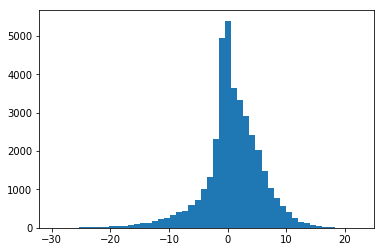

In [74]:
print('LPC')
print('SNR:', np.mean(snr_list))
print('SNR std:', np.std(snr_list))
_ = plt.hist(snr_list, bins=50)

LPC
MSE: 0.4073878
MSE std: 0.25558656


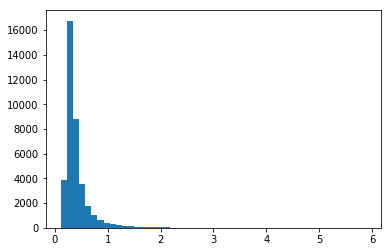

In [75]:
print('LPC')
print('MSE:', np.mean(mse_list))
print('MSE std:', np.std(mse_list))
_ = plt.hist(mse_list, bins=50)